In [1]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator

## Reduce catalog to the optical photometry F475W and F814W
## Save optical catalog to a csv file

### Takes some time to complete

In [2]:
# phast_catalog = fits.open("/Users/mmckay/phd_projects/analysis_routine/DATA/4band-merged.fits")

# phast_catalog.info()
# phast_catalog[1].header['*']

# phast_table = phast_catalog[1].data
# phast_table.shape

# phast_table = Table()
# phast_table['ra'] = phast_catalog[1].data['ra']
# phast_table['dec'] = phast_catalog[1].data['dec']

# # F475W
# phast_table['f475w_vega'] = phast_catalog[1].data['f475w_vega']
# phast_table['f475w_snr'] = phast_catalog[1].data['f475w_snr']
# phast_table['f475w_crowd'] = phast_catalog[1].data['f475w_crowd']
# phast_table['f475w_sharp'] = phast_catalog[1].data['f475w_sharp']
# phast_table['f475w_flag'] = phast_catalog[1].data['f475w_flag']


# # F814W
# phast_table['f814w_vega'] = phast_catalog[1].data['f814w_vega']
# phast_table['f814w_snr'] = phast_catalog[1].data['f814w_snr']
# phast_table['f814w_crowd'] = phast_catalog[1].data['f814w_crowd']
# phast_table['f814w_sharp'] = phast_catalog[1].data['f814w_sharp']
# phast_table['f814w_flag'] = phast_catalog[1].data['f814w_flag']

# df = phast_table.to_pandas()
# df.to_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/phast_f475W_f814W_table.csv', index=True)

# Reduce the optical catalog using the Gregersen et al 2015 criteria for RGB stars and plot color magnitude diagram

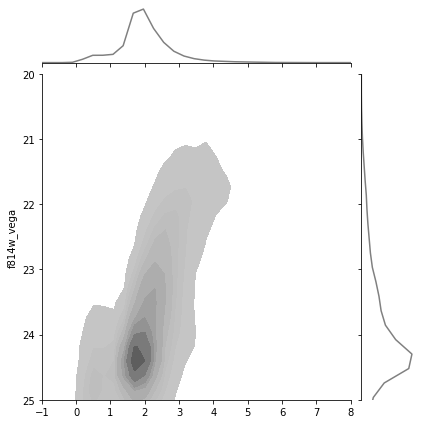

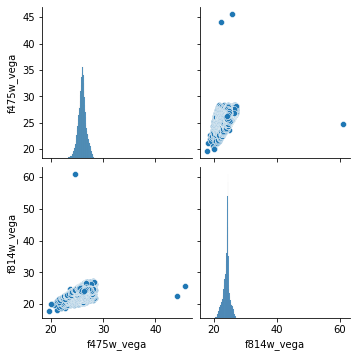

In [3]:
df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/phast_f475W_f814W_table.csv', nrows=100000)

# Gregersen et al 2015 criteria for RGB stars
phast_df = df.loc[(df['f475w_flag'] == 0.0) & (df['f814w_flag'] == 0.0)
                     & (df['f475w_snr'] >= 4.0) & (df['f814w_snr'] >= 4.0)
                     & (df['f475w_crowd']+df['f814w_crowd'] <= 1.0)
                     & ((df['f475w_sharp']+df['f814w_sharp'])**2 <= 0.075)
                    #  & (df['f814w_vega'] <= 24.5) # Apply after foreground reddening correction
                     ]
phast_df.describe()

# Plot CMD
joint = sns.jointplot(x=(phast_df['f475w_vega']-phast_df['f814w_vega']), y=phast_df['f814w_vega'], kind='kde', shade=True, color='grey')
# plt.xlim(-1, 8)
plt.ylim(25, 20)
joint.ax_marg_x.set_xlim(-1, 8)


sns.pairplot(phast_df, vars=['f475w_vega', 'f814w_vega'])


# Foreground extinction correction 

/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_924/2865687216.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phast_df['f814w_vega_ecorr'] = phast_df['f814w_vega']  + 0.596*0.17
/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_924/2865687216.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phast_df['f475w_vega_ecorr'] = phast_df['f475w_vega'] + 1.212*0.17
/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_924/2865687216.py:8: SettingWithCopyWarning: 
A value is trying to

(-1.0, 8.0)

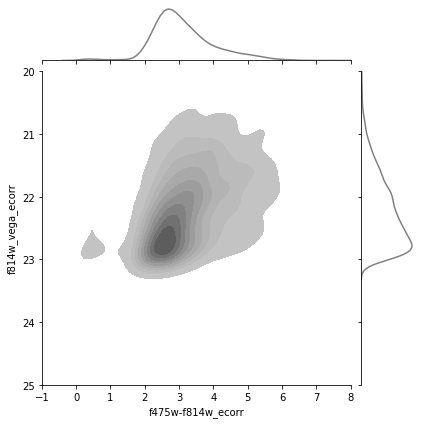

In [4]:
# # Foreground extinction correction A_lam/A_V = 0.60593
# phast_df['f814w_vega_ecorr'] = phast_df['f814w_vega']  - (2.5 * np.log(0.60593))
# phast_df['f475w_vega_ecorr'] = phast_df['f475w_vega'] - (2.5 * np.log(1.19119))

# A_lam/A_V: F814W=0.59696, F475W=1.21182 from CMD 3.7 output A_V = 0.17
phast_df['f814w_vega_ecorr'] = phast_df['f814w_vega']  + 0.596*0.17
phast_df['f475w_vega_ecorr'] = phast_df['f475w_vega'] + 1.212*0.17
phast_df['f475w-f814w_ecorr'] = phast_df['f475w_vega_ecorr']-phast_df['f814w_vega_ecorr']
phast_df = phast_df.loc[(phast_df['f814w_vega_ecorr'] <= 23.0)]
# phast_df[['f814w_vega_ecorr', 'f475w_vega_ecorr','f475w-f814w_ecorr' ]].describe()


joint = sns.jointplot(x=phast_df['f475w-f814w_ecorr'], y=phast_df['f814w_vega_ecorr'], kind='kde', shade=True, color='grey')
# plt.xlim(-1, 8)
plt.ylim(25, 20)
joint.ax_marg_x.set_xlim(-1, 8)

In [5]:
# sns.pairplot(phast_df, vars=['f475w_vega', 'f814w_vega', 'f475w_vega_ecorr', 'f814w_vega_ecorr', 'f475w-f814w_ecorr' ])

In [6]:
# Function to convert vega magnitude to bolometric magnitude
# 1. Calculate the absolute bolometric magnitude
# - M_abs = M_bol - BC_filter

In [7]:
# def vega_to_bolometric_vega(vega_mag, solar_bolmag, solar_lum):
#     vega_bol_lum = -1 * np.sqrt(vega_mag/2.5) * solar_lum
#     return solar_bolmag - vega_bol_lum

# Process the CMD output tables using cmd_table_processing.py

In [8]:
# M/H :-2.18 - 0.03 #Isopchrone table 1
# !python /Users/mmckay/phd_projects/analysis_routine/code/cmd_table_processing.py '/Users/mmckay/phd_projects/analysis_routine/DATA/CMD3_7_outputs/output901257569509.dat'
# M/H: 0.03 - 0.06 #Isopchrone table 2
!python /Users/mmckay/phd_projects/analysis_routine/code/cmd_table_processing.py '/Users/mmckay/phd_projects/analysis_routine/DATA/CMD3_7_outputs/output458449038052.dat'


Processing file: 0line [00:00, ?line/s]1 New dataframe created
Processing file: 522line [00:01, 460.99line/s]2 New dataframe created
Processing file: 659line [00:01, 406.37line/s]3 New dataframe created
Processing file: 1565line [00:03, 591.27line/s]4 New dataframe created
Processing file: 1744line [00:03, 582.74line/s]5 New dataframe created
Processing file: 1867line [00:03, 595.58line/s]6 New dataframe created
Processing file: 2057line [00:04, 618.43line/s]7 New dataframe created
Processing file: 2250line [00:04, 616.88line/s]8 New dataframe created
Processing file: 2433line [00:04, 592.18line/s]9 New dataframe created
Processing file: 2938line [00:05, 581.76line/s]10 New dataframe created
Processing file: 3126line [00:05, 605.73line/s]11 New dataframe created
Processing file: 3253line [00:06, 619.89line/s]12 New dataframe created
Processing file: 3444line [00:06, 604.34line/s]13 New dataframe created
Processing file: 3810line [00:07, 592.82line/s]14 New dataframe created
Processing 

In [9]:
# Concatenate into single table
iso_df1 = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/output901257569509/merged_output901257569509.csv')
iso_df2 = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/output458449038052/merged_output458449038052.csv')
cmd_df = pd.concat([iso_df1, iso_df2], ignore_index=True)
cmd_df.describe()


,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,Cexcess,Z,mbolmag,F435Wmag,F475Wmag,F555Wmag,F606Wmag,F625Wmag,F775Wmag,F814Wmag
count,101056.000000,101056.000000,1.010560e+05,101056.000000,101056.000000,101056.000000,101056.000000,101056.000000,101056.000000,101056.000000,...,101056.0,101056.000000,101056.000000,101056.000000,101056.000000,101056.000000,101056.000000,101056.000000,101056.000000,101056.000000
mean,0.030751,0.235967,9.602060e+00,1.276640,2.482673,1.200121,1.930644,3.587306,1.821063,4.778707,...,-1.0,0.030935,-0.056609,3.799451,3.231933,2.540124,1.885459,1.574086,0.239444,0.011866
std,0.016870,0.417161,3.552731e-15,0.279960,0.179835,0.288313,1.682522,0.114797,1.726959,2.731832,...,0.0,0.017018,4.206291,3.706848,3.663562,3.629930,3.593540,3.603359,3.708358,3.762092
min,0.000100,-2.191740,9.602060e+00,0.090000,1.081690,0.090000,-9.999000,3.344000,-1.092000,0.000000,...,-1.0,0.000034,-4.576000,-1.743000,-2.300000,-3.018000,-3.493000,-3.801000,-4.482000,-4.584000
25%,0.016500,0.052940,9.602060e+00,1.271277,2.516076,1.117000,1.177000,3.496600,0.279000,3.000000,...,-1.0,0.016440,-3.340000,1.675000,1.051000,0.375000,-0.138000,-0.439000,-2.036000,-2.422000
50%,0.030600,0.346000,9.602060e+00,1.394392,2.529421,1.318000,2.211000,3.594500,1.786000,4.000000,...,-1.0,0.030430,-0.757000,2.809000,2.314000,1.681000,0.940000,0.596000,-0.915000,-1.092000
75%,0.045300,0.543860,9.602060e+00,1.424918,2.532322,1.401000,3.244000,3.666000,3.006000,8.000000,...,-1.0,0.045810,1.827000,4.258000,3.848000,3.221000,2.831000,2.633000,1.190250,1.126250
max,0.059900,0.694320,9.602060e+00,1.443930,2.534058,1.425000,3.738000,4.000000,5.469000,9.000000,...,-1.0,0.060420,29.767000,30.028000,30.064000,30.072000,30.066000,30.068000,30.074000,30.062000


# Evaluate CMD table from cmd_table_processing.py script


In [10]:
# cmd_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/output901257569509/merged_output901257569509.csv')
# cmd_df.describe()

# Convert Isochrone tables absolute magnitudes to photometric brightness (apprent magnituides)
### m-M (distance modules) = 24.45mag +- 0.05
### m-M = -5 + 5(log(d))
### m = M - 5 + 5 * np.log10(d)
### d = np.exp((m - M + 5) / 5)

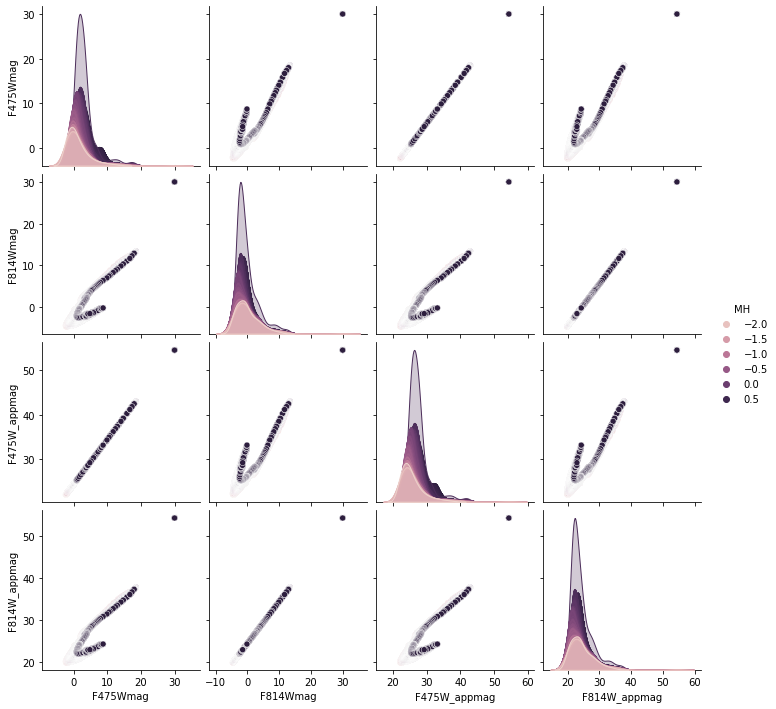

In [11]:
dist_mod = 24.45
d = 10 ** ((dist_mod + 5) / 5)
cmd_df['F475W_appmag'] = cmd_df['F475Wmag'] - 5 + 5 * np.log10(d)
cmd_df['F814W_appmag'] = cmd_df['F814Wmag'] - 5 + 5 * np.log10(d)
cmd_df[['F475Wmag', 'F814Wmag', 'F475W_appmag', 'F814W_appmag']].describe()

# Examine new columns with orignal
sns.pairplot(cmd_df[['F475Wmag', 'F814Wmag', 'F475W_appmag', 'F814W_appmag', 'MH']], hue='MH')
# assuming df is your pandas dataframe

# duplicates = cmd_df[cmd_df.duplicated('F475Wmag')]
# if len(duplicates) > 0:
#     print("Duplicate labels found:")
#     print(duplicates)
# else:
#     print("No duplicate labels found.")



/Users/mmckay/conda/envs/astrococnda3_10/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mmckay/conda/envs/astrococnda3_10/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


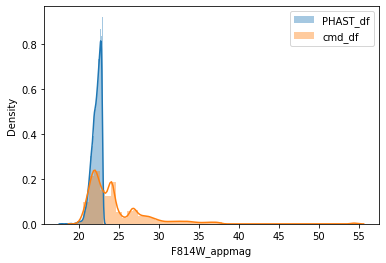

In [12]:
import seaborn as sns

sns.distplot(phast_df['f814w_vega_ecorr'], label='PHAST_df')
sns.distplot(cmd_df['F814W_appmag'], label='cmd_df')
plt.legend()
plt.show()


/Users/mmckay/conda/envs/astrococnda3_10/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mmckay/conda/envs/astrococnda3_10/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


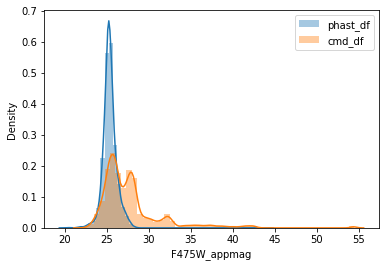

In [13]:
import seaborn as sns

sns.distplot(phast_df['f475w_vega_ecorr'], label='phast_df')
sns.distplot(cmd_df['F475W_appmag'], label='cmd_df')
plt.legend()
plt.show()


# Linear Interpolation between PHAST and Isochrone Tables
GitHub Copilot: The `LinearNDInterpolator` function from the `scipy.interpolate` module is used to create a linear interpolation object. In this code, it is used to interpolate between the 2D array of F475W and F814W magnitudes from `cmd_df` and the 2D array of f475w_vega and f814w_vega magnitudes from `phast_df`. The `interp` object is then used to find the closest index in `cmd_df` for each row in `phast_df`. The closest index is added as a new column in `phast_df`, and then `phast_df` is merged with `cmd_df` on the closest index. Finally, the merged dataframe is printed, showing the F475W and F814W magnitudes from `cmd_df` and the f475w_vega and f814w_vega magnitudes from `phast_df`.

In [14]:
from scipy.interpolate import LinearNDInterpolator

# create a 2D array of F475W and F814W magnitudes from cmd_df
cmd_arr = cmd_df[['F475W_appmag', 'F814W_appmag']].values

# create a LinearNDInterpolator object
interp = LinearNDInterpolator(cmd_arr, cmd_df.index)

# create a 2D array of f475w_vega and f814w_vega magnitudes from phast_df
filtered_arr = phast_df[['f475w_vega_ecorr', 'f814w_vega_ecorr']].values

# find the closest index in cmd_df for each row in phast_df
closest_index = interp(filtered_arr)

# add the closest index as a new column in phast_df
phast_df['closest_index'] = closest_index.astype(int)

# merge phast_df with cmd_df on closest_index
merged_df = pd.merge(phast_df, cmd_df, left_on='closest_index', right_index=True)

# print the merged dataframe
merged_df[['f475w_vega', 'f814w_vega', 'F475W_appmag', 'F814W_appmag', 'f475w-f814w_ecorr']].describe()


/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_924/3750034285.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phast_df['closest_index'] = closest_index.astype(int)


,f475w_vega,f814w_vega,F475W_appmag,F814W_appmag,f475w-f814w_ecorr
count,4930.000000,4930.000000,4930.000000,4930.000000,4930.000000
mean,25.184501,22.158304,27.940017,24.542805,3.130917
std,0.744535,0.545685,3.815811,3.899496,0.809106
min,22.287250,19.807750,22.166000,19.952000,1.153720
25%,24.738312,21.801750,25.624000,22.157250,2.555344
50%,25.103000,22.260875,26.884000,23.311000,2.956722
75%,25.545062,22.614438,28.369000,25.200000,3.539595
max,28.248500,22.898500,54.459000,54.467000,6.416720


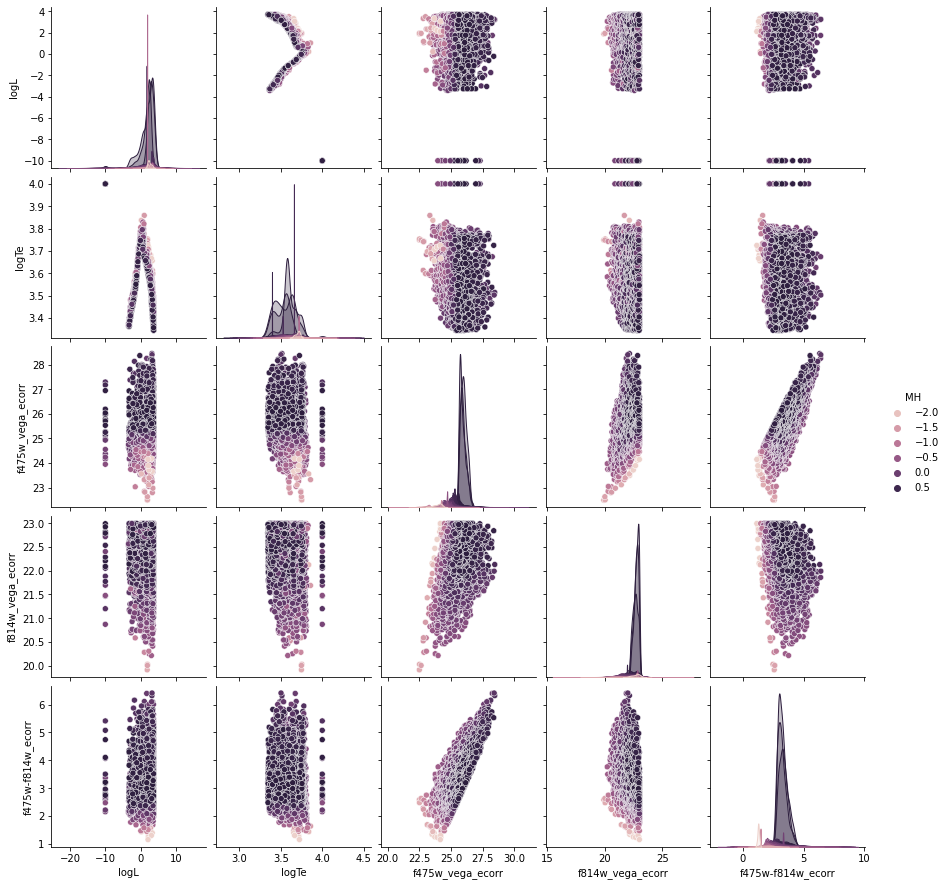

In [15]:
import seaborn as sns

sns.pairplot(merged_df[['logL', 'logTe', 'f475w_vega_ecorr', 'f814w_vega_ecorr', 'MH', 'f475w-f814w_ecorr']], hue='MH')


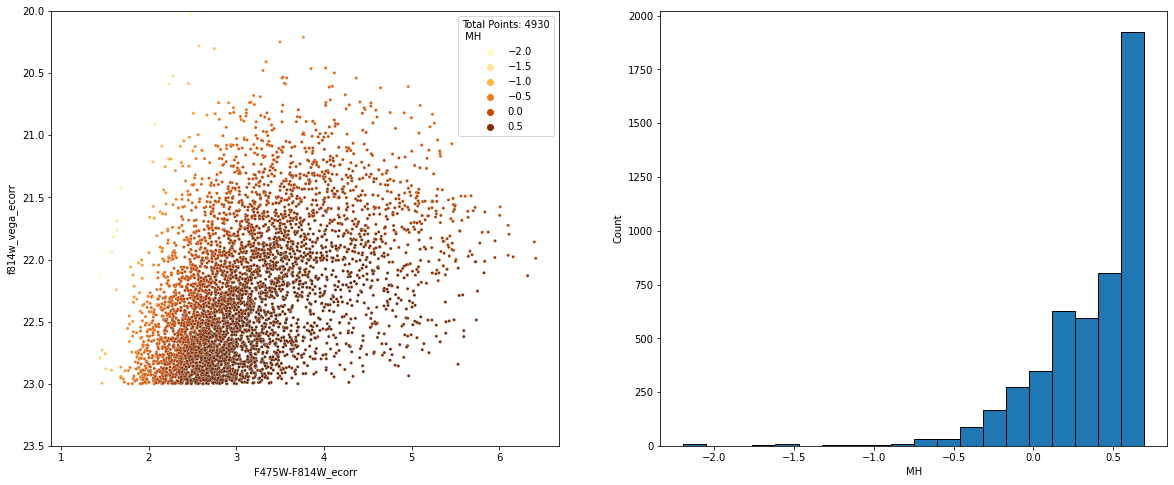

In [16]:
fig, ((ax1,ax2)) = plt.subplots(1,2, figsize=(20, 8))
sns.scatterplot(x=merged_df['f475w-f814w_ecorr'] , y=merged_df['f814w_vega_ecorr'], 
                s=10, hue=merged_df['MH'], palette='YlOrBr', alpha=1, ax=ax1)
sns.histplot(x=merged_df['MH'], alpha=1, bins=20, ax=ax2)
ax1.set_ylim(23.5, 20)
ax1.set_xlabel('F475W-F814W_ecorr')
ax1.legend(title=f"Total Points: {len(merged_df)}\n MH")
plt.show()


In [18]:
# sns.jointplot(x=merged_df['f475w_vega']-merged_df['f814w_vega'], y=merged_df['f814w_vega'], kind='kde', hue=merged_df['MH'], fill=False, legend=False)
# # sns.scatterplot(merged_df['f475w_vega']-merged_df['f814w_vega'], y=merged_df['f814w_vega'], s=1, hue=merged_df['MH'], legend=False)
# plt.gca().invert_yaxis()
# plt.xlabel('F475W-F814W')
# plt.show()


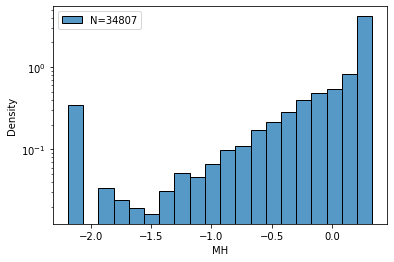

In [ ]:

import matplotlib.pyplot as plt

sns.histplot(data=merged_df, x='MH', label=f'N={len(merged_df)}', bins=20, kde=False, stat='density')
plt.yscale('log')
plt.legend()


# Examine individual metallicity range isochrone tables

In [49]:
# plot isochrone in CMD phase space
df1 = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/output901257569509/0_output901257569509.csv')
df2 = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/CMD37_csvs/output458449038052/90_output458449038052.csv')

(10.0, -5.0)

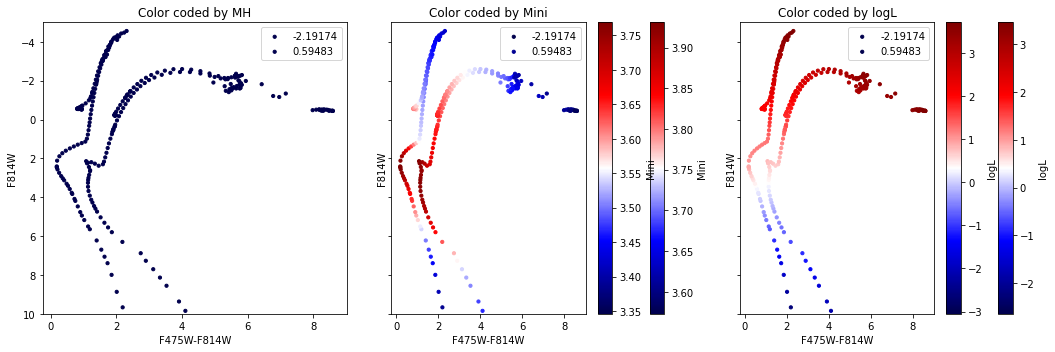

In [51]:
# create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)

# plot the data for subplot 1: color coded by MH for df1
im1 = axs[0].scatter(df1['F475Wmag']-df1['F814Wmag'], df1['F814Wmag'], c=df1['MH'], cmap='seismic', s=10, label=df1['MH'].iloc[0])
# plot the data for subplot 1: color coded by MH for df2
im2 = axs[0].scatter(df2['F475Wmag']-df2['F814Wmag'], df2['F814Wmag'], c=df2['MH'], cmap='seismic', s=10, label=df2['MH'].iloc[0])
axs[0].set_xlabel('F475W-F814W')
axs[0].set_ylabel('F814W')
axs[0].set_title('Color coded by MH')
axs[0].legend()

# add vertical colorbar for subplot 1
# cbar1 = fig.colorbar(im1, ax=axs[0], orientation='vertical', label='MH')
# cbar2 = fig.colorbar(im2, ax=axs[0], orientation='vertical', label='MH')

# plot the data for subplot 2: color coded by Mini for df1
im3 = axs[1].scatter(df1['F475Wmag']-df1['F814Wmag'], df1['F814Wmag'], c=df1['logTe'], cmap='seismic', s=10, label=df1['MH'].iloc[0])
# plot the data for subplot 2: color coded by Mini for df2
im4 = axs[1].scatter(df2['F475Wmag']-df2['F814Wmag'], df2['F814Wmag'], c=df2['logTe'], cmap='seismic', s=10, label=df2['MH'].iloc[0])
axs[1].set_xlabel('F475W-F814W')
axs[1].set_ylabel('F814W')
axs[1].set_title('Color coded by Mini')
axs[1].legend()

# add vertical colorbar for subplot 2
cbar3 = fig.colorbar(im3, ax=axs[1], orientation='vertical', label='Mini')
cbar4 = fig.colorbar(im4, ax=axs[1], orientation='vertical', label='Mini')

# plot the data for subplot 3: color coded by logL for df1
im5 = axs[2].scatter(df1['F475Wmag']-df1['F814Wmag'], df1['F814Wmag'], c=df1['logL'], cmap='seismic', s=10, label=df1['MH'].iloc[0])
# plot the data for subplot 3: color coded by logL for df2
im6 = axs[2].scatter(df2['F475Wmag']-df2['F814Wmag'], df2['F814Wmag'], c=df2['logL'], cmap='seismic', s=10, label=df2['MH'].iloc[0])
axs[2].set_xlabel('F475W-F814W')
axs[2].set_ylabel('F814W')
axs[2].set_title('Color coded by logL')
axs[2].legend()

# add vertical colorbar for subplot 3
cbar5 = fig.colorbar(im5, ax=axs[2], orientation='vertical', label='logL')
cbar6 = fig.colorbar(im6, ax=axs[2], orientation='vertical', label='logL')

plt.tight_layout()
fig.gca().invert_yaxis()
plt.ylim(10,-5)
# axs[i].invert_yaxis()


In [ ]:
w